In [1]:
import numpy as np
import cv2
from math import sin, cos
import time

import keras
from keras import backend as K

import pygame, sys
from pygame.locals import *

import io
import os
import pickle

import IPython
from IPython.display import display

from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import utils

In [3]:
K.tensorflow_backend._get_available_gpus()

W0917 22:37:39.369653 140344171657024 deprecation_wrapper.py:119] From /home/yegor/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0917 22:37:39.370662 140344171657024 deprecation_wrapper.py:119] From /home/yegor/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0917 22:37:39.371390 140344171657024 deprecation_wrapper.py:119] From /home/yegor/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0917 22:37:39.707859 140344171657024 deprecation_wrapper.py:119] From /home/yegor/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables 

[]

In [3]:
if 'cam' in vars():
    cam.release()
cam = cv2.VideoCapture(0)

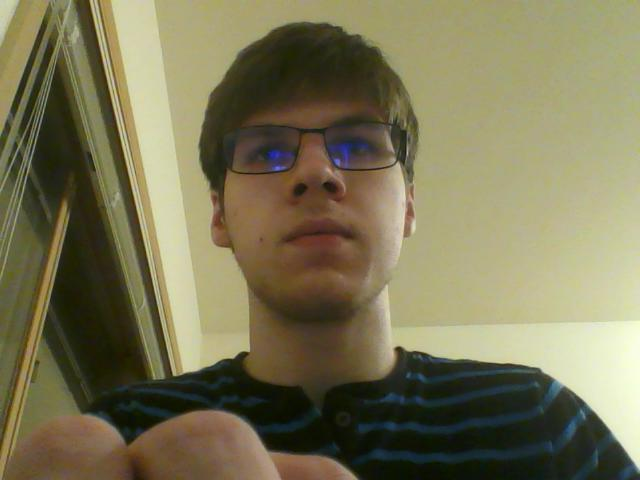

KeyboardInterrupt: 

In [12]:
image = display("", display_id='cam')

def gen(): 
    while True:
        yield True
for _ in tqdm(gen()): # tqdm for fps counter
    s, frame = cam.read()
    if s:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.flip(frame, 1)
        image.update(utils.jpeg_array_to_img(frame, 'jpeg'))

In [13]:
x_data, y_data = [], []

In [14]:
def record_view(pos):
    s, frame = cam.read()
    if s:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        x_data.append(frame)
        y_data.append(pos)

In [15]:

import pygame
import time
from pygame.locals import QUIT, KEYDOWN
from math import sin, cos

def func(t):
    return ((sin(t * 3**0.5)+1) * 1880/2, (cos(t * 2)+1) * 1040/2)


def text(font, surface, x, y, text):
    text = font.render(text, 1, (0, 0, 0))
    surface.blit(text, (x, y))


def main():
    pygame.init()
    font = pygame.font.SysFont('Noto Sans', 14)
    
    if 'cam' in vars():
        cam.release()
    cam = cv2.VideoCapture(0)
    cam.read()

    DISPLAY=pygame.display.set_mode((1920,1080),0,32)

    WHITE=(255,255,255)
    BLUE=(0,0,255)
    LIGHT_BLUE=(220,220,255)
    

    DISPLAY.fill(WHITE)
    
    offset = np.random.randint(100000)
    i = 0
    di = 0.008
    
    start = time.time()
    last = start
    
    while True:
        for event in pygame.event.get():
            if event.type==KEYDOWN:
                if event.scancode == 36:
                    start = time.time()
                    last = start
                if event.scancode == 119:
                    pygame.quit()
                    cam.release()
                    return
            if event.type==QUIT:
                pygame.quit()
                cam.release()
                return
                
        if time.time() < start + 5:
            i += 1
            
            pygame.draw.rect(DISPLAY,WHITE,(0, 0,400,40))
            text(font, DISPLAY, 5, 5, str(len(x_data)))
            pygame.draw.rect(DISPLAY,WHITE,(*func((offset + i-1) * di),40,40))
            
            x, y = func((offset + i) * di)
            
            pygame.draw.rect(DISPLAY,BLUE,(x, y,40,40))

            if i % 50 in range(40, 50):
                pygame.draw.rect(DISPLAY,WHITE,(x+10, y+10, 20, 20))
                
            if i % 50 == 45 and i >= 200:
                record_view((x, y))

            while time.time() < last + 0.01:
                time.sleep(0.001)
            last = last + 0.01
            pygame.display.update()
    
    pygame.quit()
    cam.release()

In [16]:
main()
cam.release()

In [17]:
len(x_data)

6

In [18]:
import ipywidgets as widgets
from IPython.display import display
import IPython
import keras
import io
import face_recognition

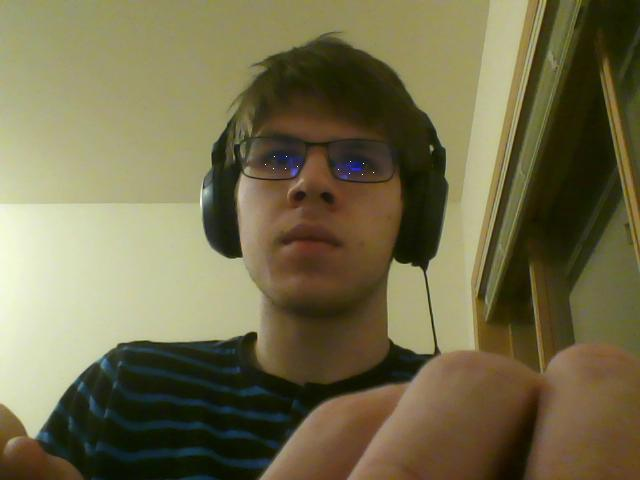

In [21]:
def show(i):
    copy = x_data[i].copy()
    landmarks = face_recognition.face_landmarks(copy)
    for face in landmarks:
        for x, y in [*face['left_eye'], *face['right_eye']]:
            copy[y][x][0] = 255
            copy[y][x][1] = 255
            copy[y][x][2] = 255
    image.update(jpeg_array_to_img(copy))

def f(c):
    show(c.new)

counter = widgets.BoundedIntText(max=len(x_data)-1)
counter.observe(f, names=['value'])


def del_i(*_):
    i = counter.value
    x_data.pop(i)
    y_data.pop(i)
    counter.max = len(x_data) - 1
    show(counter.value)

delete = widgets.Button(description='delete')
delete.on_click(del_i)


display(widgets.HBox([counter, delete]))
image = display(jpeg_array_to_img(x_data[0]), display_id='image')
show(0)


data format:
 * train and test data
   * directory per image
     * contains: image, landmarks, target

In [22]:
def store_image(path, image, landmarks, target):
    with open(path + 'landmarks.pickle', 'wb') as landmarks_p:
        pickle.dump(landmarks, landmarks_p)
    
    with open(path + 'target.pickle', 'wb') as target_p:
        pickle.dump(target, target_p)
    
    keras.preprocessing.image.array_to_img(image).save(path + 'image.png', 'png')
    

def save_image(image, target, p=0.8):
    landmarks = face_recognition.face_landmarks(image)
    
    
    # don't store image if landmarks cannot be found (or multiple people)
    if len(landmarks) != 1:
        return
    
    # decide to store it as train or test data
    path = 'data/test' if np.random.rand() > p else 'data/train'
    path = '{}/{}/'.format(path, str(len(os.listdir(path))))
    os.mkdir(path)
    
    store_image(path, image, landmarks, target)
        
        

In [23]:
for image, target in zip(tqdm(x_data), y_data):
    save_image(image, target)